<h1><center>ASDS 5303 Final Project Assignment #2 Dataset 2: The First 6 Seconds </center></h1>

## Group Members:
### Henry Berrios #1001392315
### LeMaur Kydd #1001767382

# **A. Introduction & Dataset Overview**

## <ins> Data Description: </ins>

The **911 Recordings: The First 6 Seconds** dataset is a curated collection of emergency call recordings compiled from public sources. Originally collected by the late Gary Allen, former editor of *Dispatch Monthly* magazine and 911 Dispatch website, this dataset provides valuable insight into real-world emergency situations and dispatcher responses. The dataset contains audio recordings of the first 6 seconds of civilian-initiated 911 calls, along with metadata that describes each event.

Each recording begins in a similar way, where the caller starts describing the nature of the emergency, which is often after reporting their location. The dataset also includes manually labeled metadata, including:


* Date
* State
* Potential life-threatening situation
* False alarms
* Number of deaths reported
* Description of the event

Since the dataset focuses on real-world emergency scenarios, it presents a unique challenge in speech-based machine learning and audio classification.



## <ins> Defining the ML Problem </ins>
* Supervised Learning Task: Binary Classification
* Goal: Predict whether a 911 call describes a life-threatening situation based on the first 6 seconds of audio.
* Potential Use: An AI-based triaging system to assist emergency dispatchers in identifying critical calls that require immediate attention.
* Target Variable: *potential_death* (Binary: 1 = Serious Incident, 0 = Not Serious)

# **B. Data Loading & Cleaning**

For this section, we will be pulling code from the 1st assignment, as well as improving some sections that needed changes after review.

## Importing Libraries

In [ ]:
# Import Libraries (1st assignment)
import pandas as pd
import numpy as np
from scipy.io import wavfile

import torch
import torch.nn as nn
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import librosa
import librosa.display

import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from google.colab import drive
import os

In [ ]:
# loading dataset (1st assignment)
audio_metadata = pd.read_csv('/content/911_metadata.csv') # read the dataset containing the audio metadata into a pandas dataframe

audio_folder_path = '/content/audio_files/' #folder containing the WAV files

## Cleaning the audio metadata first

In [ ]:
# keeping relevant columns
audio_metadata = audio_metadata[['date', 'state', 'deaths', 'potential_death', 'false_alarm', 'deaths_binary', 'filename']]

In [ ]:
# checking missing values
audio_metadata.isnull().sum()

,0
date,21
state,8
deaths,1
potential_death,1
false_alarm,1
deaths_binary,0
filename,0


In [ ]:
# checking data info
audio_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 710 entries, 0 to 709
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             689 non-null    object 
 1   state            702 non-null    object 
 2   deaths           709 non-null    float64
 3   potential_death  709 non-null    float64
 4   false_alarm      709 non-null    float64
 5   deaths_binary    710 non-null    int64  
 6   filename         710 non-null    object 
dtypes: float64(3), int64(1), object(3)
memory usage: 39.0+ KB


In [ ]:
# observing first 5 rows
audio_metadata.head()

,date,state,deaths,potential_death,false_alarm,deaths_binary,filename
0,2/06,Michigan,1.0,1.0,0.0,1,911_first6sec/call_2_0.wav
1,3/05,Florida,2.0,1.0,0.0,1,911_first6sec/call_8_0.wav
2,4/05,Texas,0.0,0.0,1.0,0,911_first6sec/call_9_0.wav
3,1/05,Nebraska,2.0,1.0,0.0,1,911_first6sec/call_10_0.wav
4,1/06,Oregon,0.0,0.0,1.0,0,911_first6sec/call_11_0.wav


**Handling the date column**

In [ ]:
# replacing missing values with NaN
audio_metadata['date'].replace([' nan', 'None', ''], pd.NA, inplace = True)

<ipython-input-46-96252e7c8a55>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  audio_metadata['date'].replace([' nan', 'None', ''], pd.NA, inplace = True)


In [ ]:
# fill missing date values with mode
common_date = audio_metadata['date'].mode()[0]
audio_metadata['date'].fillna(common_date, inplace = True)

In [ ]:
# split data into month and year
audio_metadata[['month', 'year']] = audio_metadata['date'].str.split('/', expand = True)

In [ ]:
# add leading zeros to month
audio_metadata['month'] = audio_metadata['month'].str.zfill(2)

# adding leading 20 if the year is < 25, otherwise 19
audio_metadata['year'] = audio_metadata['year'].astype(str)
audio_metadata['year'] = audio_metadata['year'].apply(lambda x: '20' + x if int(x) < 25 else '19' + x)

# combine to reconstruct date
audio_metadata['formatted_date'] = audio_metadata['month'] + '/' + audio_metadata['year']

In [ ]:
# checking new formatted_date
audio_metadata.head()

,date,state,deaths,potential_death,false_alarm,deaths_binary,filename,month,year,formatted_date
0,2/06,Michigan,1.0,1.0,0.0,1,911_first6sec/call_2_0.wav,02,2006,02/2006
1,3/05,Florida,2.0,1.0,0.0,1,911_first6sec/call_8_0.wav,03,2005,03/2005
2,4/05,Texas,0.0,0.0,1.0,0,911_first6sec/call_9_0.wav,04,2005,04/2005
3,1/05,Nebraska,2.0,1.0,0.0,1,911_first6sec/call_10_0.wav,01,2005,01/2005
4,1/06,Oregon,0.0,0.0,1.0,0,911_first6sec/call_11_0.wav,01,2006,01/2006


In [ ]:
# convert formatted_date to datetime and dropping any that are not a time
audio_metadata['formatted_date'] = pd.to_datetime(audio_metadata['formatted_date'], format = '%m/%Y', errors = 'coerce')
audio_metadata = audio_metadata.dropna(subset = ['formatted_date'])

In [ ]:
# extract year and month from the formatted_date datetime column
audio_metadata['year'] = audio_metadata['formatted_date'].dt.year
audio_metadata['month'] = audio_metadata['formatted_date'].dt.month

# drop date columns
audio_metadata.drop(columns = ['date', 'formatted_date'], inplace = True)

<ipython-input-52-41d31d657e09>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  audio_metadata['year'] = audio_metadata['formatted_date'].dt.year
<ipython-input-52-41d31d657e09>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  audio_metadata['month'] = audio_metadata['formatted_date'].dt.month
<ipython-input-52-41d31d657e09>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [ ]:
# checking date columns
audio_metadata.head()

,state,deaths,potential_death,false_alarm,deaths_binary,filename,month,year
0,Michigan,1.0,1.0,0.0,1,911_first6sec/call_2_0.wav,2,2006
1,Florida,2.0,1.0,0.0,1,911_first6sec/call_8_0.wav,3,2005
2,Texas,0.0,0.0,1.0,0,911_first6sec/call_9_0.wav,4,2005
3,Nebraska,2.0,1.0,0.0,1,911_first6sec/call_10_0.wav,1,2005
4,Oregon,0.0,0.0,1.0,0,911_first6sec/call_11_0.wav,1,2006


**Handling the filename column**

In [ ]:
# keeping only that's after the last '/' in filename column
audio_metadata['filename'] = audio_metadata['filename'].str.rsplit('/', n = 1, expand = True)[1]

<ipython-input-54-52b974541ccf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  audio_metadata['filename'] = audio_metadata['filename'].str.rsplit('/', n = 1, expand = True)[1]


**Imputing other columns**

In [ ]:
# potential_death, state and false_alarm will be imputed with mode
audio_metadata = audio_metadata.assign(
  potential_death = audio_metadata['potential_death'].fillna(audio_metadata['potential_death'].mode()[0]),
  false_alarm = audio_metadata['false_alarm'].fillna(audio_metadata['false_alarm'].mode()[0]),
  state = audio_metadata['state'].fillna(audio_metadata['state'].mode()[0]))

In [ ]:
# imputing with mean for deaths
audio_metadata['deaths'] = audio_metadata['deaths'].fillna(audio_metadata['deaths'].mean())

**Encoding variables**

In [ ]:
# one-hot encoding state
audio_metadata = pd.get_dummies(audio_metadata, columns = ['state'], drop_first = True)

In [ ]:
# final check
audio_metadata.head()

,deaths,potential_death,false_alarm,deaths_binary,filename,month,year,state_Arizona,state_Arkansas,state_California,...,state_Oregon,state_Pennsylvania,state_South Carolina,state_Tennessee,state_Texas,state_Utah,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin
0,1.0,1.0,0.0,1,call_2_0.wav,2,2006,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2.0,1.0,0.0,1,call_8_0.wav,3,2005,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0.0,0.0,1.0,0,call_9_0.wav,4,2005,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,2.0,1.0,0.0,1,call_10_0.wav,1,2005,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0.0,0.0,1.0,0,call_11_0.wav,1,2006,False,False,False,...,True,False,False,False,False,False,False,False,False,False


## Cleaning the audio WAV data

In [ ]:
# code to check sample rates were adapated using OpenAI's ChatGPT

sample_rates = []

# looping through audio files
for filename in os.listdir(audio_folder_path):
  if filename.endswith('.wav'):
    file_path = os.path.join(audio_folder_path, filename)
    samplerate, _ = wavfile.read(file_path)
    sample_rates.append(samplerate)

# printing the unique sample rates
print(set(sample_rates))

{48000, 8000, 22050, 16000, 44100, 24000, 32000, 11025}


In [ ]:
# code to resample audio files to 16,000 Hz was generated using OpenAI's ChatGPT

# set target sample rate
TARGET_SAMPLE_RATE = 16000

# function to load and resample audio
def load_and_resample_audio(filepath, target_sr = TARGET_SAMPLE_RATE):
  signal, sr = librosa.load(filepath, sr = target_sr) # load and resample
  return sr, signal # return new sample rate and audio signal

# dictionary to store resampled audio data
audio_data = {}

# loop through all audio files and resample them
for filename in os.listdir(audio_folder_path):
  if filename.endswith('.wav'):
    file_path = os.path.join(audio_folder_path, filename)
    try:
      sr, signal = load_and_resample_audio(file_path)
      audio_data[filename] = (sr, signal) # store resmapled data

    except Exception as e:
      print(f"Error processing file {filename}: {e}")

In [ ]:
# code to extract MFCC feature was generated using OpenAI's ChatGPT
def extract_mfcc(filename, audio_data, n_mfcc = 13):
  samplerate, signal = audio_data[filename] # get resampled audio

  #extract MFCCs
  mfccs = librosa.feature.mfcc(y = signal, sr = samplerate, n_mfcc = n_mfcc)

  # return mean of each MFCC coefficient
  return np.mean(mfccs, axis = 1)

# apply MFCC extraction to all resampled audio files
mfcc_features = {filename: extract_mfcc(filename, audio_data) for filename in audio_data}

In [ ]:
# converting MFCCs into a dataframe
mfcc_df = pd.DataFrame.from_dict(mfcc_features, orient = 'index')

# renaming columns
mfcc_df.columns = [f'mfcc_{i+1}' for i in range(mfcc_df.shape[1])]

In [ ]:
# resetting index to include the filenames (important for merging later)
mfcc_df.reset_index(inplace = True)
mfcc_df.rename(columns = {'index': 'filename'}, inplace = True)

In [ ]:
# checking to make sure data is correct
mfcc_df.head()

,filename,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,call_165_1.wav,-285.051453,147.072021,-95.122475,23.492373,3.209998,-34.399387,14.203966,-7.726354,-1.422462,11.814909,-10.586583,4.638923,-1.038076
1,call_56_0.wav,-265.528107,182.587967,-88.239380,26.989454,-14.071264,-38.457329,7.207216,-24.172731,3.152276,1.844478,-14.879568,17.258612,-4.968818
2,call_483_0.wav,-222.946518,152.427353,-76.713707,20.819912,6.185225,-21.337833,7.486639,-15.906416,-0.292753,0.076393,-13.043057,7.849473,-5.745192
3,call_621_0.wav,-173.281525,142.599457,-51.310909,8.420057,8.952278,-25.062220,-1.434401,1.161839,-11.089550,9.907050,-17.052427,8.167408,-1.247491
4,call_79_0.wav,-85.759888,153.041168,-83.040955,46.579250,-11.091568,-14.585448,7.641151,-22.205166,8.314339,-13.640339,-14.285361,6.282145,-13.139421


In [ ]:
# merging the MFCC features with the metadata
final_audio_dataset = audio_metadata.merge(mfcc_df, on = 'filename', how = 'inner')

In [ ]:
# checking the first 5 of the final audio dataset
final_audio_dataset.head()

,deaths,potential_death,false_alarm,deaths_binary,filename,month,year,state_Arizona,state_Arkansas,state_California,...,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,1.0,1.0,0.0,1,call_2_0.wav,2,2006,False,False,False,...,15.966405,-7.343820,-24.486908,1.289998,-19.420135,-0.306071,-1.039879,-12.136690,8.766991,-6.482018
1,2.0,1.0,0.0,1,call_8_0.wav,3,2005,False,False,False,...,4.099893,10.013773,-15.562420,3.637351,0.807152,-0.121653,1.010673,-3.819564,-0.571596,-1.275510
2,0.0,0.0,1.0,0,call_9_0.wav,4,2005,False,False,False,...,6.405340,-7.470667,-40.291611,12.424075,-28.371588,-11.297830,-0.625510,-20.440136,-3.854191,0.710319
3,2.0,1.0,0.0,1,call_10_0.wav,1,2005,False,False,False,...,-12.408360,-2.823838,-12.919912,-9.299513,-8.089900,-10.357327,10.996255,-9.394347,-1.169220,-1.851839
4,0.0,0.0,1.0,0,call_11_0.wav,1,2006,False,False,False,...,1.076098,4.090524,-66.347183,-1.868305,-17.837589,-40.351601,5.569083,-26.620871,-33.332920,9.664045


**Target Variable**

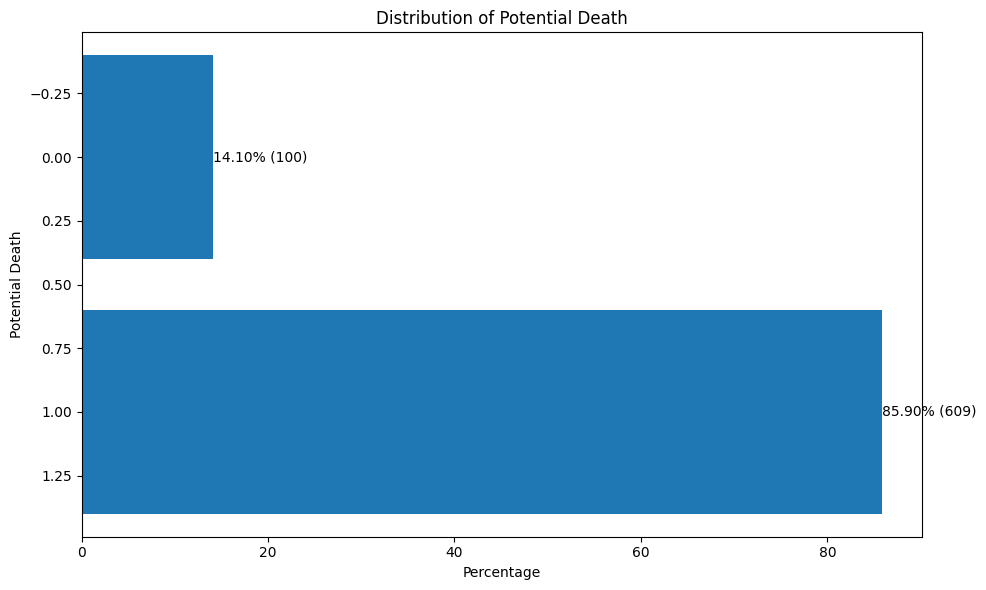

In [ ]:
# CODE FOR PLOT BELOW GENERATED BY GEMINI AI

# pulled from assignment 1 and adapted to cleaned dataset

# prompt: create bar plot of the audio_metadata.potential_death column to show the distribution of the target variable show percentages and frequencies reverse the order of the bars, smallest at the left

# Calculate frequencies and percentages
target_variable_counts = final_audio_dataset['potential_death'].value_counts()
total = len(final_audio_dataset)
percentages = (target_variable_counts / total) * 100

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(percentages.index, percentages.values)

plt.xlabel('Percentage')
plt.ylabel('Potential Death')
plt.title('Distribution of Potential Death')

# Add frequency labels to the bars
for bar, percentage, freq in zip(bars, percentages.values, target_variable_counts.values):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f"{percentage:.2f}% ({freq})",
             va='center', ha='left')

# Reverse the order of bars
plt.gca().invert_yaxis()


plt.tight_layout()
plt.show()

# **C. Convert Dataset into Tensor Format**

In [ ]:
# isolating X and y variables
X = final_audio_dataset.drop(columns = ['filename', 'potential_death'])
y = final_audio_dataset['potential_death']

In [ ]:
# apply SMOTE to the unbalanced data
smote = SMOTE(sampling_strategy = 'auto', random_state = 2)
X_balanced, y_balanced = smote.fit_resample(X, y)

In [ ]:
# split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size = 0.2, random_state = 2)

Before converting our data to tensors, they need to be standardized. In this case, we used StandardScaler from sklearn.preprocessing. Standardized features allow for machine learning models, as well as deep learning networks, to perform better (Scikit-learn Developers, 2023). Additionally, PyTorch models often converge faster and more stably when the variables are standardized (Raschka, Liu & Mirjalili, 2022).

In [ ]:
# standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Once the data gets standardized, we convert it into PyTorch tensors. Tensors are the core data structure for PyTorch. These tensors are similar to NumPy arrays, but are optimized for deep learning computations (Paszke et al., 2019). PyTorch tensors also allow for the use of GPUs using CUDA, which significantly speeds up training (NVIDIA, 2020). In order for us to create neural networks in PyTorch, we convert the data into tensor inputs.

In our code, we use *.values* for the *y_train* and *y_test* since they are Pandas series, and PyTorch does not accept Pandas objects. By using *.values*, we convert them into NumPy arrays, which PyTorch can use (Scikit.learn Developers, 2023). Moreover, we use *.view(-1, 1)* to ensure that the target variable y is formatted as a column vector (N, 1), rather than a 1D array (N,) (PyTorch Community, 2023). This prevents the shape to become mismatched during training. Finally, *dtype = torch.float32* is used to optimize the deep learning computations. *float32* reduces memory usage while still maintaining precision (NVIDIA, 2020). Without this specificiation, PyTorch may default to torch.float64, which is more intensive and can slow down computations (PyTorch Developers, 2023).

In [ ]:
# convert train and test sets to tensors
# code adapted and assisted by OpenAi's ChatGPT (OpenAI, 2025) and from PyTorch Documentation (Pazke et al., 2019)

X_train_tensor = torch.tensor(X_train_scaled, dtype = torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype = torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype = torch.float32).view(-1, 1)

# **D. Save Processed Data**

In [ ]:
# pulled and adapted from dataset 3 prep
# mounting my drive
drive.mount('/content/drive')

#save to drive
torch.save(X_train_tensor, '/content/drive/MyDrive/X_train_tensor_d2.pt')
torch.save(X_test_tensor, '/content/drive/MyDrive/X_test_tensor_d2.pt')
torch.save(y_train_tensor, '/content/drive/MyDrive/y_train_tensor_d2.pt')
torch.save(y_test_tensor, '/content/drive/MyDrive/y_test_tensor_d2.pt')

Mounted at /content/drive


# **References**
- NVIDIA. (2020). CUDA Programming Guide. Retrieved from https://developer.nvidia.com/cuda-toolkit.
- OpenAI. (2025). Response generated by ChatGPT [Large language model]. OpenAI. Retrieved from https://chat.openai.com
- Paszke, A., Gross, S., Massa, F., Lerer, A., Bradbury, J., Chanan, G., et al. (2019). PyTorch: An imperative style, high-performance deep learning library. Retrieved from https://proceedings.neurips.cc/paper_files/paper/2019/file/bdbca288fee7f92f2bfa9f7012727740-Paper.pdf.
- PyTorch Community. (2024). torch.Tensor.view. Retrieved from https://pytorch.org/docs/stable/generated/torch.Tensor.view.html/.
- PyTorch Developers. (2023). Data types in PyTorch. Retrieved from https://pytorch.org/docs/stable/tensors.html#torch-tensor.
- Raschka, S., Liu, Y., & Mirjalili, V. (2022). Machine Learning with PyTorch and Scikit-Learn. Packt Publishing.
- Scikit-learn Developers. (2023). Preprocessing data: StandardScaler. Retrieved from https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html.